In [1]:
from smt.sampling_methods import LHS
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
from matplotlib.animation import FuncAnimation

In [2]:
import chaospy as cp


# Define the Ishigami function
def ishigami(x):
#     return x[0]**2 + 5 * np.sin(x[1]) + 0.5 * x[2] * x[0] - 2 * x[1] * x[2]
    return np.sin(x[0]) + 7 * np.sin(x[1])**2 + 0.1 * x[2]**4 * np.sin(x[0])


def compute_true_sobol_indices(func, order=4):
    # Define the joint distribution of the inputs
    distribution = cp.J(cp.Uniform(-np.pi, np.pi), cp.Uniform(-np.pi, np.pi), cp.Uniform(-np.pi, np.pi))

    # Construct the orthogonal polynomials
    polynomial_expansion = cp.orth_ttr(order, distribution)

    # Use point collocation to determine the PCE coefficients
    samples = distribution.sample(2*len(polynomial_expansion), rule="random")
    evaluations = np.apply_along_axis(func, 0, samples)
    pce = cp.fit_regression(polynomial_expansion, samples, evaluations)

    # Compute Sobol indices based on the PCE coefficients
    sobol_indices = cp.Sens_t(pce, distribution)
    
    return sobol_indices

# True Sobol indices using PCE
true_sobol_indices = compute_true_sobol_indices(ishigami)
true_sobol_indices

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


array([0.44899195, 0.58089761, 0.35117153])

<IPython.core.display.Javascript object>


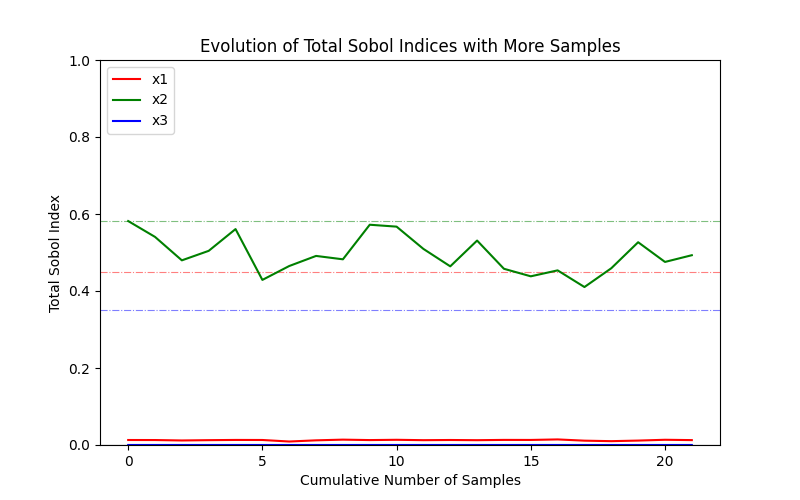

In [3]:
# Ensure interactive plots
%matplotlib notebook

def get_data():
    cnx = mysql.connector.connect(user='root', password='password', host='127.0.0.1', database='mydb')
    cursor = cnx.cursor()
    cursor.execute("SELECT x1, x2, x3 FROM my_table")
    data = cursor.fetchall()
    cursor.close()
    cnx.close()
    return np.array(data)

def sobol_generate(dimensions, num_samples):
    xlimits = np.array([[0, 1]]*dimensions)
    sampling = LHS(xlimits=xlimits)
    return sampling(num_samples)

def total_sobol_index(A, B, func):
    """Compute the total Sobol indices for a function given sample matrices A and B."""
    n = A.shape[1]
    f_A = np.apply_along_axis(func, 1, A)
    V = np.var(f_A)
    
    S_T = []
    for i in range(n):
        A_Bi = A.copy()
        A_Bi[:, i] = B[:, i]
        f_A_Bi = np.apply_along_axis(func, 1, A_Bi)
        V_A_Bi = np.var((f_A - f_A_Bi) / 2)
        S_T.append(V_A_Bi / V)
    return S_T

# This will hold our data history
sobol_history = { "x1": [], "x2": [], "x3": [] }

fig, ax = plt.subplots(figsize=(8, 5))

def update(frame):
    data = get_data()
    n_samples = data.shape[0]
    
    # Generate Sobol sequences for A and B matrices
    A = sobol_generate(3, n_samples)
    B = sobol_generate(3, n_samples)
    
    sobol_indices = total_sobol_index(A, B, ishigami)
    
    # Update our history
    sobol_history["x1"].append(sobol_indices[0])
    sobol_history["x2"].append(sobol_indices[1])
    sobol_history["x3"].append(sobol_indices[2])
    
    ax.clear()
    
    colors = {
        "x1": "red",
        "x2": "green",
        "x3": "blue"
    }
    
    for label, color in colors.items():
        ax.plot(sobol_history[label], label=label, color=color)
    
    ax.axhline(y=0, color='black', linewidth=0.8)
    ax.set_ylim([0, 1])  # Sobol indices range between 0 and 1
    ax.set_xlabel("Cumulative Number of Samples")
    ax.set_ylabel("Total Sobol Index")
    ax.set_title("Evolution of Total Sobol Indices with More Samples")
    ax.legend(loc='upper left')
    
    
    ax.axhline(y=true_sobol_indices[0], color=colors["x1"], linestyle='-.', alpha=0.5, linewidth=0.8, zorder=0, label='True x1')
    ax.axhline(y=true_sobol_indices[1], color=colors["x2"], linestyle='-.', alpha=0.5, linewidth=0.8, zorder=0, label='True x2')
    ax.axhline(y=true_sobol_indices[2], color=colors["x3"], linestyle='-.', alpha=0.5, linewidth=0.8, zorder=0, label='True x3')
    
    
    
    return ax,

ani = FuncAnimation(fig, update, interval=1000, blit=True)
plt.show()

<IPython.core.display.Javascript object>


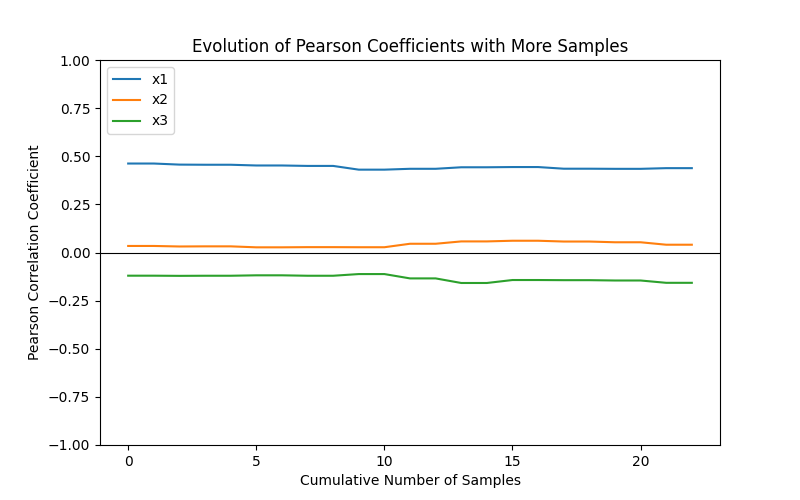

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
from scipy.stats import pearsonr
from matplotlib.animation import FuncAnimation

# Ensure interactive plots
%matplotlib notebook


def get_data():
    cnx = mysql.connector.connect(user='root', password='password', host='127.0.0.1', database='mydb')
    cursor = cnx.cursor()
    cursor.execute("SELECT x1, x2, x3 FROM my_table")
    data = cursor.fetchall()
    cursor.close()
    cnx.close()
    return np.array(data)

def compute_correlations(data):
    Y = np.apply_along_axis(ishigami, 1, data)
    correlations = []
    for i in range(data.shape[1]):
        r, _ = pearsonr(data[:, i], Y)
        correlations.append(r)
    return correlations

# This will hold our data history
correlation_history = { "x1": [], "x2": [], "x3": [] }

fig, ax = plt.subplots(figsize=(8, 5))

def update(frame):
    data = get_data()
    correlations = compute_correlations(data)
    
    # Update our history
    correlation_history["x1"].append(correlations[0])
    correlation_history["x2"].append(correlations[1])
    correlation_history["x3"].append(correlations[2])
    
    ax.clear()
    
    for label, hist in correlation_history.items():
        ax.plot(hist, label=label)
    
    ax.axhline(y=0, color='black', linewidth=0.8)
    ax.set_ylim([-1, 1])
    ax.set_xlabel("Cumulative Number of Samples")
    ax.set_ylabel("Pearson Correlation Coefficient")
    ax.set_title("Evolution of Pearson Coefficients with More Samples")
    ax.legend(loc='upper left')
    return ax,

ani = FuncAnimation(fig, update, interval=1000, blit=True)
plt.show()


<IPython.core.display.Javascript object>


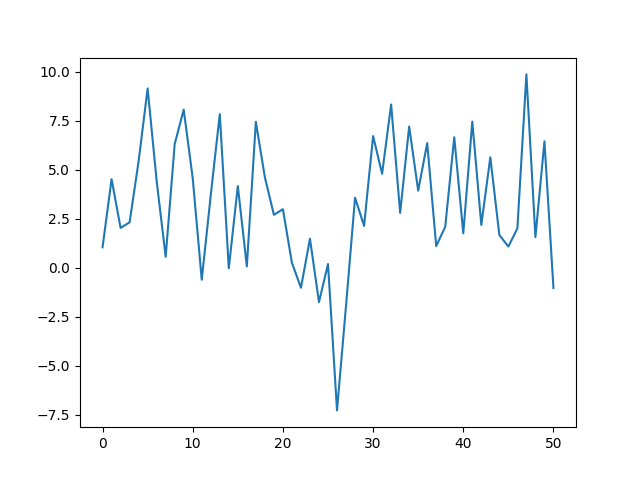

In [5]:
%matplotlib notebook

import mysql.connector
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Ishigami function
def ishigami(x1, x2, x3):
    return np.sin(x1) + 7*np.sin(x2)**2 + 0.1*x3**4 * np.sin(x1)

# Connect to the database and get data
def get_data():
    config = {
        'user': 'root',
        'password': 'password',
        'host': '127.0.0.1',
        'port': '3306',
        'database': 'mydb'
    }
    cnx = mysql.connector.connect(**config)
    cursor = cnx.cursor()
    cursor.execute("SELECT x1, x2, x3 FROM my_table")
    rows = cursor.fetchall()
    cursor.close()
    cnx.close()
    return rows

# Function to update the line data for the animation
def update(frame):
    data = get_data()
    y_data = [ishigami(*row) for row in data]
    line.set_ydata(y_data)
    line.set_xdata(range(len(y_data)))
    ax.relim()
    ax.autoscale_view()
    return line,

# Set up the figure, axis, and plot element
fig, ax = plt.subplots()
x_data, y_data = [], []
line, = ax.plot(x_data, y_data)

# This animation function will update the plot every 5 seconds
ani = FuncAnimation(fig, update, interval=5000, blit=True)
plt.show()


In [8]:
import mysql.connector

config = {
    'user': 'root',
    'password': 'password',
    'host': 'localhost',
    'database': 'mydb'
}

cnx = mysql.connector.connect(**config)
cursor = cnx.cursor()
cursor.execute("SELECT * FROM my_table")
rows = cursor.fetchall()
for row in rows:
    print(row)
cursor.close()
cnx.close()

(1, 2.30473, 2.93361, 0.24644)
(2, -0.312927, -1.09581, -2.19301)
(3, -1.44953, 2.40505, -1.07875)
(4, -2.93766, 0.647782, -1.1162)
(5, 0.921766, -2.19675, -0.808145)
(6, 1.23644, 0.545863, 2.85873)
(7, 1.5126, -3.12904, 2.42024)
(8, 0.361678, 2.96993, 0.339975)
(9, 0.0198785, 1.89639, -0.0710917)
(10, 1.84275, 2.34217, 2.45505)
(11, -2.66739, 1.56256, 2.56755)
(12, -0.800147, -2.99769, 0.841874)
(13, -1.49261, -2.17707, -0.724454)
(14, 1.33034, -1.71943, -0.60326)
(15, -1.95147, 2.39254, -2.24111)
(16, -2.56866, 1.43577, 2.51456)
(17, -3.11641, 0.181127, 2.69185)
(18, 0.674174, -1.40398, 0.56812)
(19, 1.58498, 2.57173, -1.99193)
(20, 0.877494, -0.46275, 1.62338)
(21, 0.130098, 0.507082, -3.10274)
(22, -0.247483, 0.330888, -1.77637)
(23, -0.527585, -2.2695, 3.09494)
(24, -0.0754734, 0.510024, 1.97071)
(25, -1.49869, -2.5299, 2.35362)
(26, -0.105874, 2.92431, 1.31737)
(27, -1.34769, -2.52486, 3.06773)
(28, -1.04092, -0.475846, -2.32772)
(29, 0.678237, -0.096796, 2.60241)
(30, -1.58417, 